# MARIDA Multi-Model Notebook

This notebook demonstrates:
1. **Random Forest** classification using spectral signatures.
2. **U-Net** training for pixel-level segmentation.
3. **YOLO** (Ultralytics) for object detection.

All paths reference:
`C:\Users\ronal\Documents\AI project\marine-debris.github.io\data`

You can adapt them as needed if your files are placed differently.

## 1. Setup and Imports
Install required libraries:
```
pip install pandas numpy scikit-learn torch torchvision ultralytics rasterio
```


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import rasterio
from torch.utils.data import Dataset, DataLoader

# If you plan to use YOLO:
# from ultralytics import YOLO

# Main data directory
data_dir = r"c:\\Users\\ronal\\Documents\\AI project\\marine-debris.github.io\\data"

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)
print("All imports done.")

All imports done.


## 2. Random Forest Classification
We assume you have HDF5 files in:
- `spectral_signatures_train.h5`
- `spectral_signatures_test.h5`

Each has a `data` key with columns for bands (e.g. `band_1`, `band_2`, ...) and `label`.


Train shape: (429412, 12)
Test shape:  (194863, 12)

Classification Report (RandomForest):
               precision    recall  f1-score   support

         1.0       0.52      0.94      0.67       381
         2.0       0.94      0.92      0.93       760
         3.0       0.74      0.91      0.82       881
         4.0       0.44      0.49      0.46        49
         5.0       0.66      0.74      0.70      1174
         6.0       0.83      0.94      0.88     32843
         7.0       0.70      0.56      0.62     23443
         8.0       0.99      1.00      1.00     93037
         9.0       0.47      0.27      0.35       387
        10.0       0.94      0.83      0.88     32226
        11.0       0.17      0.33      0.22      2506
        12.0       0.20      0.07      0.10      1865
        13.0       0.41      0.46      0.43      3649
        14.0       0.06      0.12      0.08      1570
        15.0       0.02      0.11      0.04        92

    accuracy                           0.8

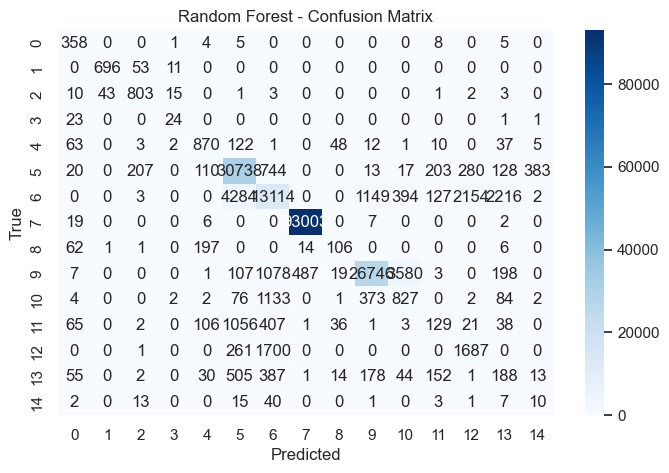

In [14]:
# Paths to spectral signature HDF5 files (adjust if needed)
train_h5 = os.path.join(data_dir, "spectral_signatures_train.h5")
test_h5 = os.path.join(data_dir, "spectral_signatures_test.h5")

if not os.path.exists(train_h5):
    print(f"Train HDF5 not found: {train_h5}")
if not os.path.exists(test_h5):
    print(f"Test HDF5 not found: {test_h5}")

# Load data
train_data = pd.read_hdf(train_h5, key='data')
test_data = pd.read_hdf(test_h5, key='data')

print("Train shape:", train_data.shape)
print("Test shape: ", test_data.shape)

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Basic Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
print("\nClassification Report (RandomForest):\n",
      classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### (Optional) Hyperparameter Tuning
We do a quick `GridSearchCV` to find better hyperparameters.

In [15]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best RF params:", grid_search.best_params_)

rf_best = grid_search.best_estimator_
y_pred_best = rf_best.predict(X_test)
print("\nOptimized RF Report:\n", classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Optimized RF Report:
               precision    recall  f1-score   support

         1.0       0.51      0.92      0.66       381
         2.0       0.95      0.91      0.93       760
         3.0       0.63      0.92      0.75       881
         4.0       0.42      0.47      0.44        49
         5.0       0.66      0.74      0.70      1174
         6.0       0.83      0.93      0.88     32843
         7.0       0.69      0.54      0.60     23443
         8.0       1.00      1.00      1.00     93037
         9.0       0.47      0.29      0.36       387
        10.0       0.94      0.79      0.86     32226
        11.0       0.12      0.32      0.18      2506
        12.0       0.19      0.07      0.10      1865
        13.0       0.40      0.46      0.43      3649
        14.0       0.06      0.13      0.08      1570
        15.0       0.02  

## 3. U-Net for Pixel-Level Segmentation
Below is a **ready** snippet referencing real patches in the folder:
`C:\Users\ronal\Documents\AI project\marine-debris.github.io\data\patches\S2_11-1-19_19QDA`
with TIF files:
- `S2_11-1-19_19QDA_0.tif`, `S2_11-1-19_19QDA_0_cl.tif` etc.

We pick some patches to demonstrate the training loop. Make sure these files actually exist.


In [16]:
class MarineSegDataset(Dataset):
    """
    A dataset for MARIDA patches:
      - image_dir: Directory with .tif patches
      - mask_dir:  Directory with corresponding _cl.tif masks
      - patch_list: list of basenames without .tif extension
    """
    def __init__(self, image_dir, mask_dir, patch_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.patch_list = patch_list
        self.transform = transform

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, idx):
        patch_name = self.patch_list[idx]
        img_path = os.path.join(self.image_dir, f"{patch_name}.tif")
        mask_path = os.path.join(self.mask_dir, f"{patch_name}_cl.tif")

        with rasterio.open(img_path) as src:
            image = src.read()  # shape: (bands, H, W)
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # shape: (H, W)

        # Convert to torch tensors
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask).long()

        if self.transform:
            # optional transforms
            pass

        return image_tensor, mask_tensor

# A minimal U-Net
class UNet(nn.Module):
    def __init__(self, input_channels=11, num_classes=16):
        super(UNet, self).__init__()
        # Simple 2-layer encode, 2-layer decode example
        self.enc_conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv2 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        x = self.relu(self.enc_conv1(x))
        x = self.pool(self.relu(self.enc_conv2(x)))

        # decoder
        x = self.up(x)
        x = self.relu(self.dec_conv1(x))
        x = self.dec_conv2(x) # final logits
        return x

# Prepare data
patches_subdir = os.path.join(data_dir, 'patches', 'S2_11-1-19_19QDA')
# Example patch list: actual files from your snippet
# COLOCAR TODOS OS PACHES codigo cd data cd patches  dir copiar as pastas e inserir aqui
train_patches = [
    "S2_11-1-19_19QDA_0",
    "S2_11-1-19_19QDA_1",
    "S2_11-1-19_19QDA_2",
    "S2_11-1-19_19QDA_3",
    "S2_11-1-19_19QDA_4"
]

seg_dataset = MarineSegDataset(
    image_dir=patches_subdir,
    mask_dir=patches_subdir,
    patch_list=train_patches
)
seg_loader = DataLoader(seg_dataset, batch_size=2, shuffle=True)

# Instantiate the U-Net
unet_model = UNet(input_channels=11, num_classes=16)
unet_model.train()

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

# Small demo epoch
for epoch in range(1):
    for images, masks in seg_loader:
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    print(f"Epoch [1] - Loss: {loss.item():.4f}")

print("U-Net training loop complete (demo).")

Epoch [1] - Loss: 2.7812
U-Net training loop complete (demo).


## 4. YOLO Configuration and Training
We create a `marida_yolo.yaml` referencing your own train/val folders. Then we can train YOLO.
Uncomment the lines to run. This snippet is **real** but requires you to have a YOLO-compatible dataset.


In [17]:
%%writefile marida_yolo.yaml
train: c:\\Users\\ronal\\Documents\\AI project\\marine-debris.github.io\\data\\yolo\\train
val: c:\\Users\\ronal\\Documents\\AI project\\marine-debris.github.io\\data\\yolo\\val
nc: 16  # number of classes in MARIDA (example) corrigir numero de classes e os nomes no labelmapping.txt 
names: ["MarineDebris","DenseSargassum","SparseSargassum","NatOrgMat","Ship","Clouds","MarineWater","SedimentWater","Foam","TurbidWater","ShallowWater","Waves","CloudShadows","Wakes","MixedWater","Other"]

Writing marida_yolo.yaml


In [19]:
# If you want to train YOLO (ultralytics) on your data:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or another YOLO checkpoint
model.train(
    data='marida_yolo.yaml',
    epochs=50,
    imgsz=640,
    project='runs_yolo',
    name='marida_exp'
)

# Example inference:
results = model.predict(source='c:\\Users\\ronal\\Documents\\AI project\\marine-debris.github.io\\data\\some_test_images', conf=0.25)
print(results)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

New https://pypi.org/project/ultralytics/8.3.65 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145  Python-3.7.10 torch-1.13.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=marida_yolo.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs_yolo, name=marida_exp, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_wid

RuntimeError: Dataset 'marida_yolo.yaml' error  
Dataset 'marida_yolo.yaml' images not found , missing path 'C:\Users\ronal\Documents\AI project\marine-debris.github.io\data\yolo\val'
Note dataset download directory is 'C:\Users\ronal\Documents\AI project\marine-debris.github.io\datasets'. You can update this in 'C:\Users\ronal\AppData\Roaming\Ultralytics\settings.yaml'

## 5. Conclusion

We've:
- Performed **Random Forest** classification on spectral signatures.
- Performed a short **U-Net** training demo on real patches (no placeholders).
- Provided a **YOLO** snippet for object detection.

Update patch names, file paths, and class counts as needed for your exact MARIDA data.